In [1]:
## first softmax version
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.special import expit
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
# Cell 1: Import the module
from gp_softmax_torch_works import *
## first softmax version
%load_ext autoreload
%autoreload 2
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [5]:
# Generate synthetic data
N = 100  # Number of individuals
D = 5    # Number of diseases
T = 50   # Number of time points
K = 3    # Number of topics
P = 5    # Number of genetic covariates
torch.manual_seed(42)
np.random.seed(42)
# 1. Generate synthetic data with true parameters
true_data = generate_synthetic_data(N=N, D=D, T=T, K=K, P=P, return_true_params=True)
Y = true_data['Y']
G = true_data['G']
prevalence = true_data['prevalence']
event_times = true_data['event_times']
true_pi = true_data['pi']

# Initialize the model
model = AladynSurvivalModel(N, D, T, K, P, G, Y, prevalence)


Epoch 0, Loss: 9670.2900
Epoch 10, Loss: 4198.3003
Epoch 20, Loss: 3392.3613
Epoch 30, Loss: 3073.9368
Epoch 40, Loss: 2919.0464
Epoch 50, Loss: 2846.8420
Epoch 60, Loss: 2837.4497
Epoch 70, Loss: 2782.2510
Epoch 80, Loss: 2739.1392
Epoch 90, Loss: 2705.6541


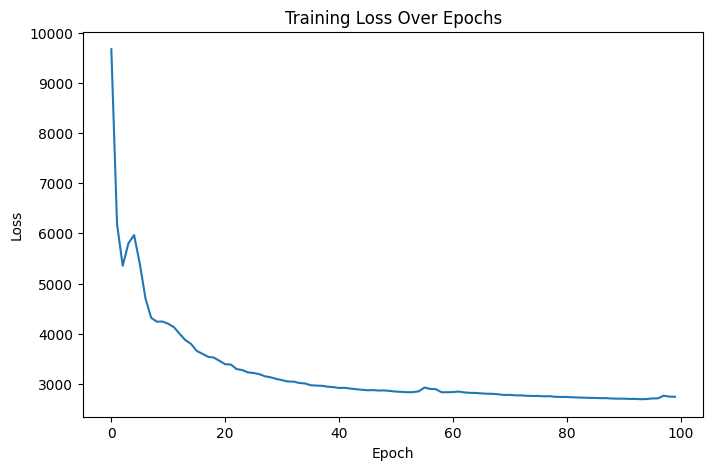

In [6]:

# Fit the model
num_epochs = 100
learning_rate = 1e-3
lambda_reg = 1e-2  # L2 regularization weight for gamma
losses = model.fit(event_times, num_epochs=num_epochs, learning_rate=learning_rate, lambda_reg=lambda_reg)

# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [4]:

# 4. Get model predictions
pi_pred, theta_pred, phi_pred = model.forward()



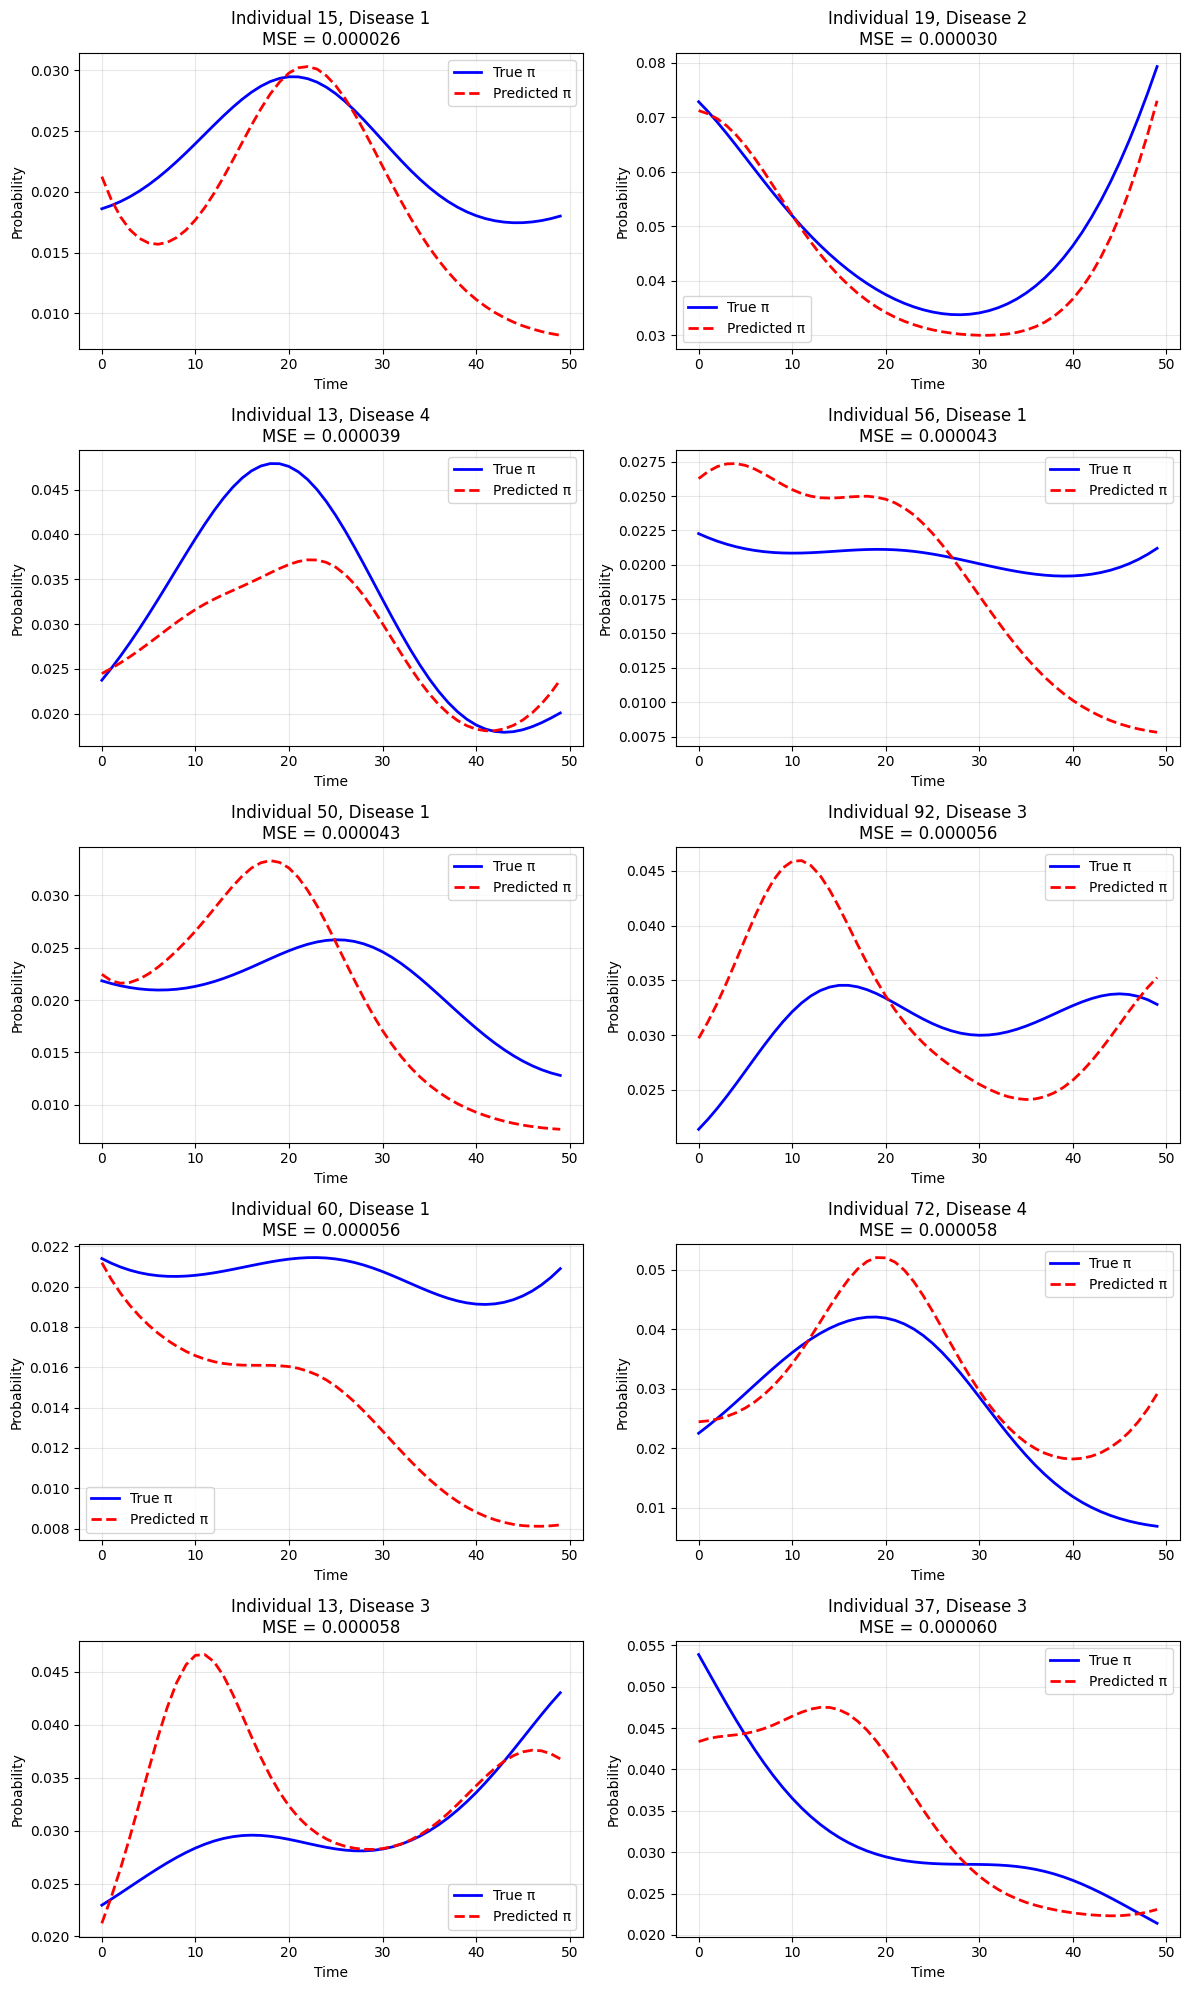

In [5]:

pi_pred, theta_pred, phi_pred = model.forward()
plot_best_matches(true_pi, pi_pred, n_samples=10, n_cols=2)


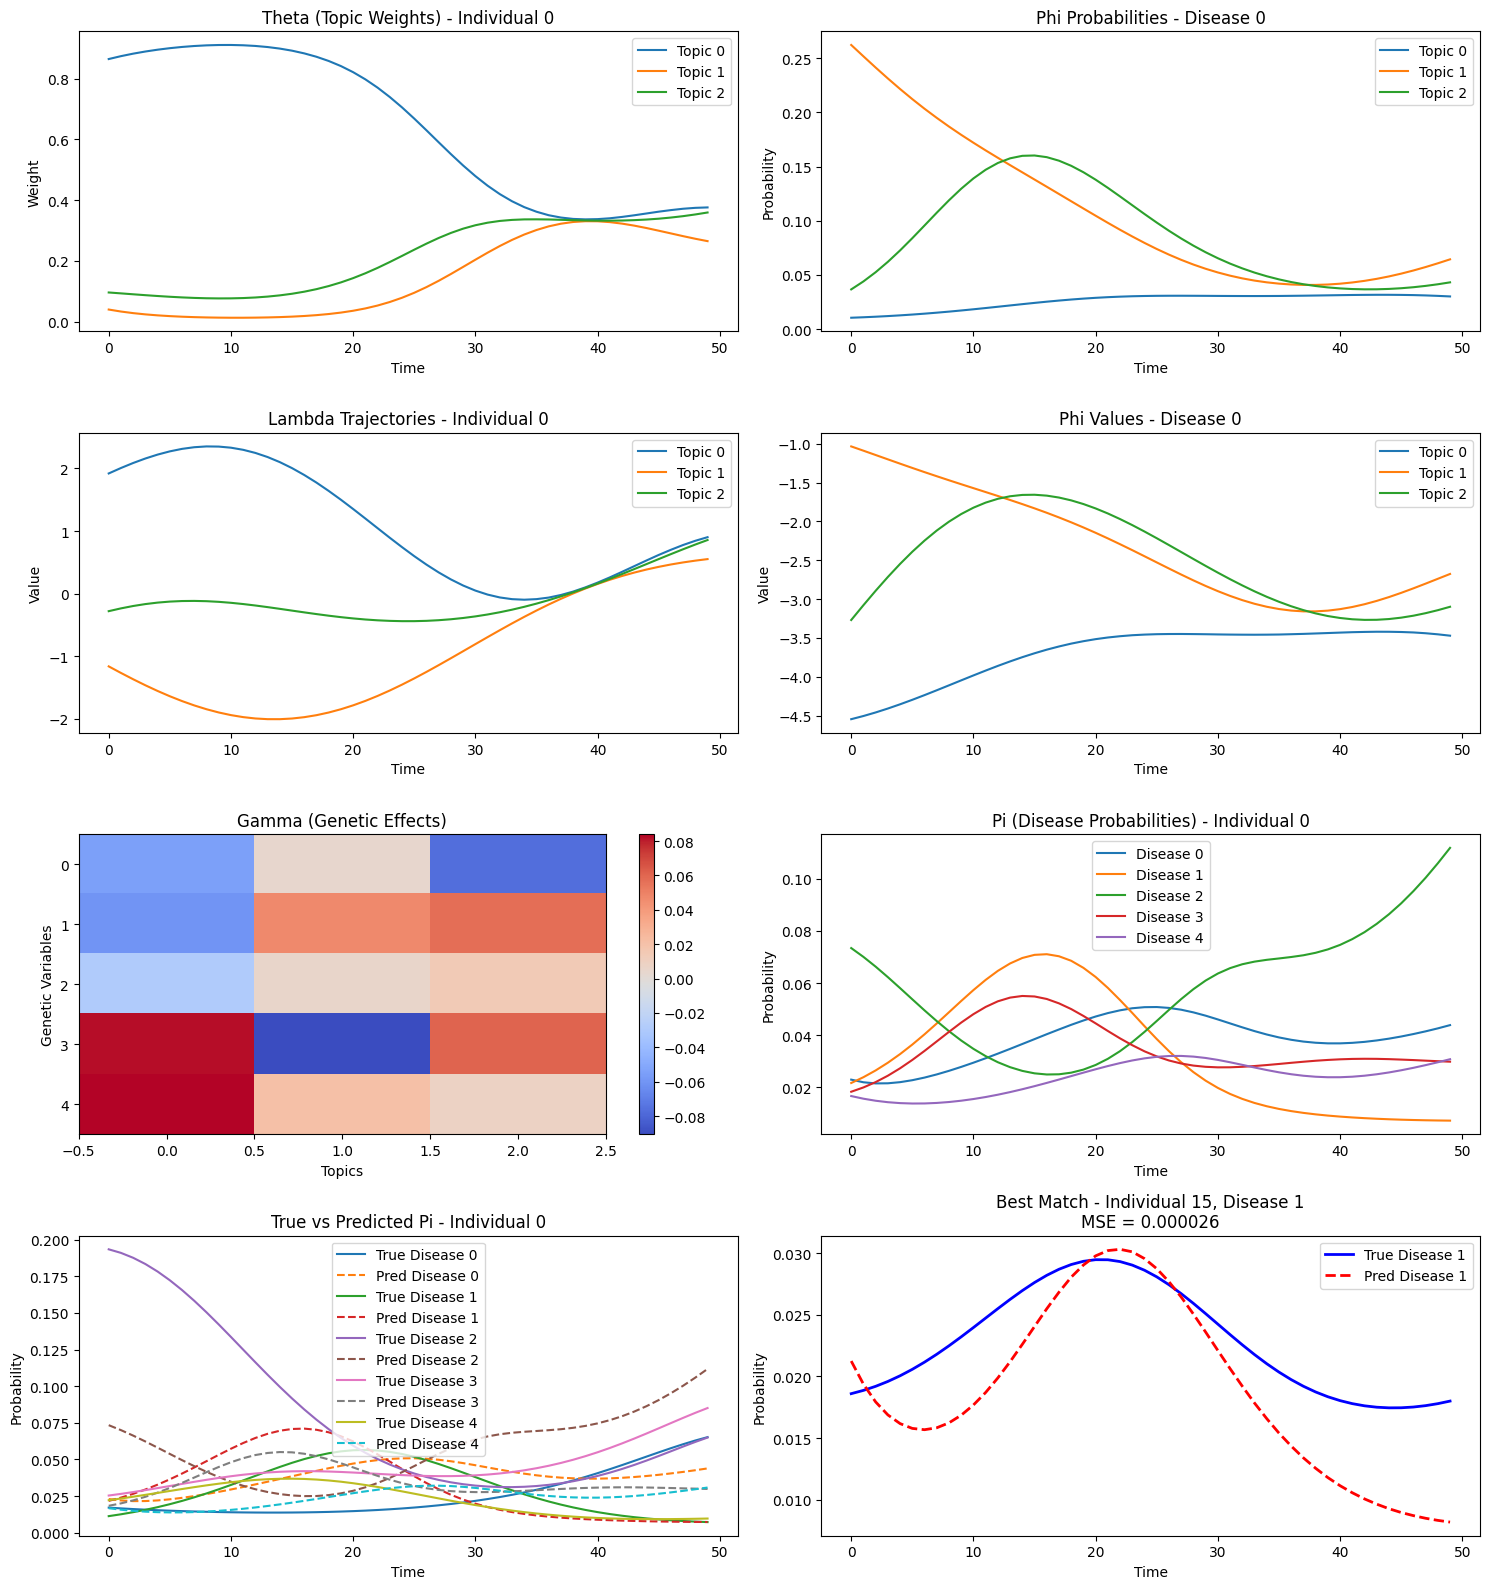

In [7]:
pi_pred, theta, phi_prob = model.forward()

# Convert predictions to numpy
pi_pred_np = pi_pred.detach().numpy()

fig, axes = plt.subplots(4, 2, figsize=(15, 16))  # Made taller for extra row

# 1. Plot theta (topic weights) for first few individuals
theta_np = theta.detach().numpy()
for k in range(K):
    axes[0, 0].plot(theta_np[0, k, :], label=f'Topic {k}')
axes[0, 0].set_title('Theta (Topic Weights) - Individual 0')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Weight')
axes[0, 0].legend()

# 2. Plot phi probabilities for first few diseases
phi_prob_np = phi_prob.detach().numpy()
for k in range(K):
    axes[0, 1].plot(phi_prob_np[k, 0, :], label=f'Topic {k}')
axes[0, 1].set_title('Phi Probabilities - Disease 0')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].legend()

# 3. Plot lambda trajectories
lambda_np = model.lambda_.detach().numpy()
for k in range(K):
    axes[1, 0].plot(lambda_np[0, k, :], label=f'Topic {k}')
axes[1, 0].set_title('Lambda Trajectories - Individual 0')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Value')
axes[1, 0].legend()

# 4. Plot raw phi values
phi_np = model.phi.detach().numpy()
for k in range(K):
    axes[1, 1].plot(phi_np[k, 0, :], label=f'Topic {k}')
axes[1, 1].set_title('Phi Values - Disease 0')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Value')
axes[1, 1].legend()

# 5. Plot gamma (genetic effects) as heatmap
gamma_np = model.gamma.detach().numpy()
im = axes[2, 0].imshow(gamma_np, aspect='auto', cmap='coolwarm')
axes[2, 0].set_title('Gamma (Genetic Effects)')
axes[2, 0].set_xlabel('Topics')
axes[2, 0].set_ylabel('Genetic Variables')
plt.colorbar(im, ax=axes[2, 0])

# 6. Plot final survival probabilities for first individual
pi_np = pi_pred.detach().numpy()
for d in range(D):
    axes[2, 1].plot(pi_pred_np[0, d, :], label=f'Disease {d}')
axes[2, 1].set_title('Pi (Disease Probabilities) - Individual 0')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('Probability')
axes[2, 1].legend()

for d in range(D):
    axes[3, 0].plot(true_pi[0, d, :], '-', label=f'True Disease {d}')
    axes[3, 0].plot(pi_pred_np[0, d, :], '--', label=f'Pred Disease {d}')
axes[3, 0].set_title('True vs Predicted Pi - Individual 0')
axes[3, 0].set_xlabel('Time')
axes[3, 0].set_ylabel('Probability')
axes[3, 0].legend()

# 8. Plot true vs predicted pi for a good match
# Find a good matching individual-disease pair
mse = np.mean((true_pi - pi_pred_np)**2, axis=2)  # N×D
best_idx = np.unravel_index(np.argmin(mse), mse.shape)
i_best, d_best = best_idx

axes[3, 1].plot(true_pi[i_best, d_best, :], 'b-', 
                label=f'True Disease {d_best}', linewidth=2)
axes[3, 1].plot(pi_pred_np[i_best, d_best, :], 'r--', 
                label=f'Pred Disease {d_best}', linewidth=2)
axes[3, 1].set_title(f'Best Match - Individual {i_best}, Disease {d_best}\nMSE = {mse[i_best, d_best]:.6f}')
axes[3, 1].set_xlabel('Time')
axes[3, 1].set_ylabel('Probability')
axes[3, 1].legend()

plt.tight_layout()
plt.show()



In [8]:
def plot_all_pi_comparison(true_pi, pred_pi):
    """
    Plot all predicted vs true pi values
    
    Parameters:
    true_pi: numpy array (N×D×T)
    pred_pi: torch tensor (N×D×T)
    """
    # Convert to numpy and flatten
    pred_pi_np = pred_pi.detach().numpy()
    true_flat = true_pi.flatten()
    pred_flat = pred_pi_np.flatten()
    
    # Create plot
    plt.figure(figsize=(10, 10))
    
    # Scatter plot
    plt.scatter(true_flat, pred_flat, alpha=0.1, color='blue')
    
    # Add diagonal line
    max_val = max(true_flat.max(), pred_flat.max())
    min_val = min(true_flat.min(), pred_flat.min())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect prediction')
    
    # Add correlation coefficient
    corr = np.corrcoef(true_flat, pred_flat)[0,1]
    mse = np.mean((true_flat - pred_flat)**2)
    
    plt.title(f'True vs Predicted π\nR: {corr:.3f}, MSE: {mse:.6f}')
    plt.xlabel('True π')
    plt.ylabel('Predicted π')
    plt.legend()
    
    # Make plot square
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.show()


Epoch 0, Loss: 9928.5020
Epoch 10, Loss: 4397.2578
Epoch 20, Loss: 3623.6150
Epoch 30, Loss: 3299.0542
Epoch 40, Loss: 3124.3452
Epoch 50, Loss: 3037.8330
Epoch 60, Loss: 2991.0295
Epoch 70, Loss: 2951.1685
Epoch 80, Loss: 2918.8679
Epoch 90, Loss: 2896.4194


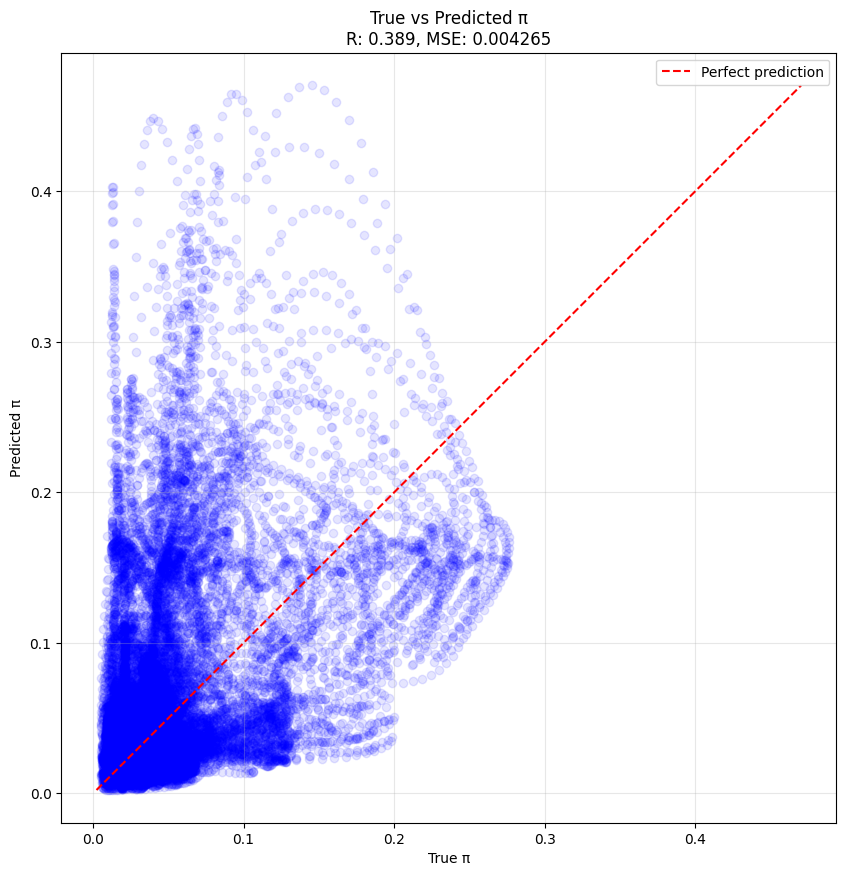

In [26]:
# Generate synthetic data
N = 100  # Number of individuals
D = 5    # Number of diseases
T = 50   # Number of time points
K = 3    # Number of topics
P = 5    # Number of genetic covariates


true_data = generate_synthetic_data(N=N, D=D, T=T, K=K, P=P, return_true_params=True)
Y = true_data['Y']
G = true_data['G']
prevalence = true_data['prevalence']
event_times = true_data['event_times']
true_pi = true_data['pi']

# 2. Initialize model
model = AladynSurvivalModel(N, D, T, K, P, G, Y, prevalence)

# 3. Fit model
losses = model.fit(event_times, num_epochs=100)

# 4. Get model predictions
pi_pred, theta_pred, phi_pred = model.forward()

plot_all_pi_comparison(true_pi, pi_pred)
